In [3]:
import numpy as np
import pandas as pd

import IPython.display as ipd

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("Data/features_30_sec.csv")

In [5]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
def display_sample(file_path):
    plt.figure(figsize=(12, 4))
    data, sample_rate = librosa.load(file_path)
    print("Sample rate: ", sample_rate)
    print("min-max range: ", np.min(data), 'to', np.max(data))
    _ = librosa.display.waveplot(data, sr=sample_rate)

Sample rate:  22050
min-max range:  -0.8402405 to 0.885376


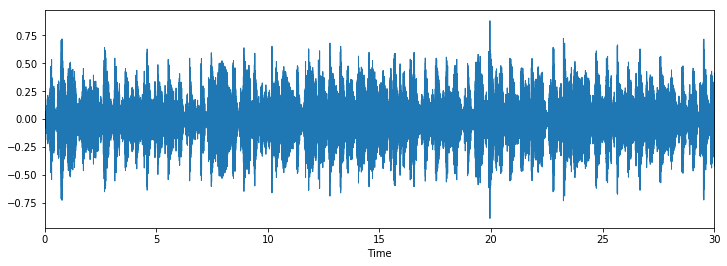

In [7]:
display_sample("Data/genres_original/blues/blues.00000.wav")

In [8]:
librosa_audio, librosa_sample_rate = librosa.load("Data/genres_original/blues/blues.00000.wav")

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)

(40, 1293)
[[-211.48465086 -208.94482648 -193.90886432 ... -109.99914277
   -86.84641504  -79.03764389]
 [  99.02296527  101.24677684  102.2439539  ...  150.07934372
   138.89685143  140.24707739]
 [ -10.63469419   -9.34669827    1.91543412 ...  -50.79513665
   -36.61398204  -31.44394114]
 ...
 [   7.12403028    3.10410834   -3.06285765 ...   -1.48643886
    -5.42342838   -2.54601125]
 [  -1.86897333   -1.37408256   -4.71681795 ...   -4.07676137
    -5.16280266   -0.48264616]
 [   4.05602289    2.34714411   -1.6581437  ...    2.92016706
    -1.32439635   -3.56338816]]


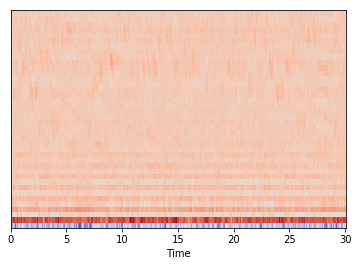

In [10]:
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis="time")

In [11]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccscaled = np.mean(mfccs.T, axis=0)
    
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    
    return mfccscaled

In [13]:
folder_path = "Data/genres_original/"
features = []

for index, row in df.iterrows():
    file_name = folder_path +row["label"] +"/"+row["filename"] 
    
    class_label = row["label"]
    data = extract_features(file_name)
    features.append([file_name, data, class_label])

In [14]:
features_df = pd.DataFrame(features, columns=["filename", "feature", "label"])

In [15]:
features_df.head()

,filename,feature,label
0,Data/genres_original/blues/blues.00000.wav,"[-113.57065006014844, 121.57179828375648, -19....",blues
1,Data/genres_original/blues/blues.00001.wav,"[-207.50168497354247, 123.9912585331953, 8.955...",blues
2,Data/genres_original/blues/blues.00002.wav,"[-90.72259498919979, 140.4463057367266, -29.09...",blues
3,Data/genres_original/blues/blues.00003.wav,"[-199.54419996864743, 150.0909082667387, 5.662...",blues
4,Data/genres_original/blues/blues.00004.wav,"[-160.33771108012152, 126.21963120678232, -35....",blues


In [16]:
features_df.tail()

,filename,feature,label
995,Data/genres_original/rock/rock.00095.wav,"[-153.64096500673784, 109.86463957172475, -23....",rock
996,Data/genres_original/rock/rock.00096.wav,"[-142.39203007153975, 116.18963062959543, -32....",rock
997,Data/genres_original/rock/rock.00097.wav,"[-124.95226634901407, 115.17715767843684, -47....",rock
998,Data/genres_original/rock/rock.00098.wav,"[-225.007766934651, 123.64675796070165, -9.724...",rock
999,Data/genres_original/rock/rock.00099.wav,"[-235.16199605539342, 123.8700999837467, -22.5...",rock
